In [54]:
import imp
import os
import subprocess
import h5py
import numpy as np
from astropy.time import Time
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import HourLocator as HourLocator
from matplotlib.dates import MinuteLocator as MinuteLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units as u
from astropy.time import TimeDelta
from ipywidgets import interact
import matplotlib.patches as patches
from importlib import reload 
import DVA_RFI as rfi


#### Change the directory to where the files are located" ####
day ='25'
directory = '../DVA/Data_Files/DVA_Day_Surveys/'

### Read in the file listing azimuth scan start and stop times:

In [55]:
scan_id = []    # The scan id number
scan_start = []  # Start time of the scan (UTC)
scan_stop = []   # Stop time of the scan (UTC)

# Read in the data and store it in arrays:
with open(directory+'DVAsurvey_phase1_day0'+day+'.txt') as fp:
    for line in fp:       
        scan_id.append(int(line.split()[0]))
        scan_start.append(line.split()[1]+'T'+line.split()[2][0:12])
        scan_stop.append(line.split()[3]+'T'+line.split()[4][0:12])
        
# Print out the scan numbers with their start and stop times:
for i in range(0,len(scan_id)):
    print(f"{scan_id[i]:04}",scan_start[i],scan_stop[i])

# Convert start and stop times to Modified Julian Day (MJD).
# This is needed for plotting and for selecting out data collected
# between particular times:
scan_start_mjd = Time(scan_start, format='isot',scale='utc').mjd
scan_stop_mjd  = Time(scan_stop,  format='isot',scale='utc').mjd


1052 2022-07-04T03:57:53.110 2022-07-04T04:15:55.184
2565 2022-07-04T04:20:37.406 2022-07-04T04:38:39.310
2566 2022-07-04T04:40:22.266 2022-07-04T04:58:24.003
1271 2022-07-04T05:03:42.716 2022-07-04T05:21:44.818
1272 2022-07-04T05:23:27.291 2022-07-04T05:41:29.292
2857 2022-07-04T05:48:35.269 2022-07-04T06:06:37.317
0124 2022-07-04T06:11:19.190 2022-07-04T06:29:21.101
1637 2022-07-04T06:34:03.920 2022-07-04T06:52:06.005
0342 2022-07-04T06:57:23.897 2022-07-04T07:15:25.930
1927 2022-07-04T07:21:55.804 2022-07-04T07:39:58.034
1928 2022-07-04T07:42:16.530 2022-07-04T08:00:18.319
2001 2022-07-04T08:03:48.814 2022-07-04T08:21:51.062
2002 2022-07-04T08:24:09.373 2022-07-04T08:42:11.545
2075 2022-07-04T08:45:41.821 2022-07-04T09:03:44.188
2148 2022-07-04T09:07:50.625 2022-07-04T09:25:52.832
2149 2022-07-04T09:27:35.229 2022-07-04T09:45:37.044
2150 2022-07-04T09:47:56.026 2022-07-04T10:05:57.828
2151 2022-07-04T10:07:40.752 2022-07-04T10:25:42.662
2152 2022-07-04T10:27:25.410 2022-07-04T10:45:

### Read in scan files and stich them together:

In [56]:
t_set = []
az_set = []
dec_set = []
ra_set = []
el_set = []
noise_set = []
trim_flag = []

scan0 = f"{scan_id[0]:04}"

# Use one of the scans to get the list of frequencies:
freq_channel_increment = 1 #TODO: I'll have to change this to 1 once I am sure I'm reading the data correctly

file = h5py.File(directory+'dva_survey_raw_scan_'+scan0+'.h5','r')
freq = file['data']['beam_0']['band_SB0']['frequency'][::freq_channel_increment]/1e6
df = freq[1] - freq[0]

# Create empty arrays for the power data:
RR_set = np.empty([0,len(freq)])
LL_set = np.empty([0,len(freq)])
reRL_set = np.empty([0,len(freq)])
imRL_set = np.empty([0,len(freq)])



# Loop through all the scans in the "scan_num" list:

for i in scan_id[3:4]:
# for i in scan_id[0:1]:
    print(i)
    # select the file:
    file = h5py.File(directory+'dva_survey_raw_scan_'+f"{i:04}"+'.h5','r')
    print(file)

    # access the correct location in the file structure:
    dataset = file['data']['beam_0']['band_SB0']['scan_0']

    # Add the position and time data to the corresponding arrays:
    dec_set = np.concatenate([dec_set,dataset['metadata']['declination']])
    ra_set = np.concatenate([ra_set,dataset['metadata']['right_ascension']])
    el_set = np.concatenate([el_set,dataset['metadata']['elevation']])
    az_set = np.concatenate([az_set,dataset['metadata']['azimuth']])
    t_set = np.concatenate([t_set,dataset['metadata']['utc']])
    noise_set = np.concatenate([noise_set,dataset['metadata']['noise_state']]) #This is a "mask" for noise regions 1 = noise 0=all good
    trim_flag = np.concatenate([trim_flag,dataset['metadata']['trim_scan_flag']])

    # Add the spectrometer power data to the corresponding arrays:
    RR_set = np.concatenate([RR_set,dataset['data'][:,0,::freq_channel_increment]],axis=0)
    LL_set = np.concatenate([LL_set,dataset['data'][:,1,::freq_channel_increment]],axis=0)
    reRL_set = np.concatenate([reRL_set,dataset['data'][:,2,::freq_channel_increment]],axis=0)
    imRL_set = np.concatenate([imRL_set,dataset['data'][:,3,::freq_channel_increment]],axis=0)

polarized = []
for i,j in zip(reRL_set,imRL_set):
    PI = np.sqrt((i**2)+(j**2))
    polarized.append(PI)
polarized_set = np.array(polarized)

noise_idx = np.array(np.where(noise_set == 1))

    
t_plt = Time(t_set, format='isot',scale='utc').mjd

#NOTE: Local change because Leo only has 5 scans on his computer
scan_id = [1052]

1271
<HDF5 file "dva_survey_raw_scan_1271.h5" (mode r)>


### Read in persistent RFI mask

In [57]:
i = 0
RFI_mask_idx = []
with open('../DVA/Data_Files/RFIpersist_mask.txt') as fp:
    for line in fp:
        if i>0: 
            RFI_mask_idx.append(int(line.split()[0]))
        i=i+1
RFI_mask_idx = np.array(RFI_mask_idx)

### Apply masks

In [58]:
polarized_set[noise_idx, :] = np.nan
polarized_set[:,RFI_mask_idx] = np.nan

LL_set[noise_idx, :] = np.nan
LL_set[:,RFI_mask_idx] = np.nan

RR_set[noise_idx, :] = np.nan
RR_set[:,RFI_mask_idx] = np.nan

# 2d Visualization plot

In [59]:
def DVA_Singlescan_Time_Cross_Section(freq_idx, duration, baseline_multiplier):
    fs = 14
    scan_baseline = np.nanmedian(polarized_set[duration,freq_idx])

    possible_RFI_idxes = np.where(polarized_set[:, freq_idx] >= scan_baseline*baseline_multiplier)
    polarized_set_masked = polarized_set.copy()
    polarized_set_masked[possible_RFI_idxes, :] = np.nan


    fig,axs1 = plt.subplots(1,1,figsize=(12.5,6))  
    axs1.plot(t_plt[duration], polarized_set[duration,freq_idx],color='red', linewidth = 0.5, label = "Possible RFI")
    axs1.plot(t_plt[duration], polarized_set_masked[duration,freq_idx],color='black', linewidth = 0.65, label = "Masked Polarized Set")


    axs1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs1.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs1.set_xlabel('Time (UTC)',fontsize=fs)
    axs1.set_ylabel("Power")
    axs1.set_xlim(t_plt[duration][0],t_plt[duration][-1])

    # axs1.axhline(abs_threshold,xmin=0,xmax=3,c="green",linewidth=1,zorder=0, label = "Absolute Threshold")
    axs1.axhline(scan_baseline*baseline_multiplier,xmin=0,xmax=3,c="purple",linewidth=1,zorder=0, label = "Relative Threshold")
    axs1.axhline(scan_baseline,xmin=0,xmax=3,c="red",linewidth=1,zorder=0, label = "Scan Baseline")
    axs1.set_ylim(ymax = (baseline_multiplier+1)*scan_baseline, ymin=0)
    # axs1.set_ylim(ymax=1e6, ymin=0)
    axs1.tick_params(axis='both',labelsize=fs)   
    axs1.legend()

In [60]:
def ValidateStartTime(idx, delta):
    if (idx-delta) <= 0:
        validaded_start = 0
    else:
        validaded_start = idx-delta
    return validaded_start

def ValidateEndTime(idx, delta, array):
    if (idx+delta) >= (len(array)-1):
        validaded_end = (len(array)-1)
    else:
        validaded_end = idx+delta
    return validaded_end

In [61]:
reload(rfi)
def DVA_Plot_RFI(rfi_number, freq_chosen):
    freq_idx = rfi.find_nearest_idx(freq, freq_chosen)
    freq_measured = freq[freq_idx]
    freq_threshold = 1e5
    base_mult = 2
        
    confirmed_RFI_results = rfi.RFI_Detection(freq_slope_threshold=freq_threshold, baseline_multiplier=base_mult, freq_idx = freq_idx, polarized_set = polarized_set)
    confirmed_rfi_idxes = rfi.GenerateRfiIndexes(confirmed_RFI_results, freq)

    try:
        if len(confirmed_RFI_results) == 0:
                raise Exception("No confirmed RFI Events found")
        #Arbitraty constants for visualization   

        time_framing = 100
        freq_framing = 100
        time_buffer = 10
        freq_buffer = 10

        # DETERMINE RFI REGION --------------------------------------------------------------------------------------------------------
        t1_plt = confirmed_RFI_results[rfi_number][0]
        t2_plt = confirmed_RFI_results[rfi_number][1]
        freq1 = confirmed_RFI_results[rfi_number][2]
        freq2 = confirmed_RFI_results[rfi_number][3]
        print("RFI starting frequency: {:.2f}.\nRFI ending frequency: {:.2f}".format(freq1, freq2))


        buffered_start_time = ValidateStartTime(t1_plt, time_buffer)
        buffered_end_time = ValidateEndTime(t2_plt, time_buffer, t_plt)

        framed_start_time = ValidateStartTime(t1_plt, time_framing)
        framed_end_time = ValidateEndTime(t2_plt, time_framing, t_plt)

        # PLOTTING WATERFALL RFI ------------------------------------------------------------------------------------------------------

        RFI_duration_time = t_plt[framed_start_time:framed_end_time]
        RFI_freq_bandwith = freq[freq1 - freq_framing: freq2 + freq_framing]

        fig,axs = plt.subplots(1,2,figsize=(25,10)) 
        fs = 16

        # Create a Rectangle patch ---------------------------------------------------------------------------------------------------
        RFI_detected = patches.Rectangle((t_plt[t1_plt], freq[freq1]), np.abs(t_plt[t2_plt] - t_plt[t1_plt]), np.abs(freq[freq2] - freq[freq1]), linewidth=1.5, edgecolor='r', facecolor='none')
        RFI_detected_LL = patches.Rectangle((t_plt[t1_plt], freq[freq1]), np.abs(t_plt[t2_plt] - t_plt[t1_plt]), np.abs(freq[freq2] - freq[freq1]), linewidth=1.5, edgecolor='r', facecolor='none')
        # Add the patch to the Axes0
        axs[0].add_patch(RFI_detected)
        axs[1].add_patch(RFI_detected_LL)

        #Polarized Waterfall ---------------------------------------------------------------------------------------------------------------------------
        power_min = np.nanmedian((10.*np.log10(polarized_set[buffered_start_time: buffered_end_time,freq1-freq_buffer: freq2+freq_buffer].T)))
        power_max = np.nanmax((10.*np.log10(polarized_set[buffered_start_time: buffered_end_time,freq1-freq_buffer: freq2+freq_buffer].T)))

        im_pol = axs[0].imshow(10.*np.log10(polarized_set[framed_start_time: framed_end_time,freq1-freq_framing: freq2+freq_framing].T),aspect='auto',vmin=power_min,vmax=power_max,origin='lower',
                extent=[RFI_duration_time[0],RFI_duration_time[-1],RFI_freq_bandwith[0],RFI_freq_bandwith[-1]])

        divider = make_axes_locatable(axs[0])
        cax = divider.append_axes('right', size='2%', pad=0.05)
        cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
        cbar.ax.tick_params(labelsize=fs) 
        cbar.set_label('Power (dB)', fontsize=fs)

        axs[0].set_xlim(RFI_duration_time[0],RFI_duration_time[-1])
        axs[0].tick_params(axis='both', labelsize=fs)
        axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        axs[0].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
        axs[0].set_xlabel('Time (UTC)',fontsize=fs)        
        axs[0].set_ylabel('Frequency (MHz)',fontsize=fs)
        axs[0].set_title('Polarized Set at Frequency {:.2f}'.format(freq_measured), size = fs)

        #LL Waterfall ---------------------------------------------------------------------------------------------------------------------------
        power_min = np.nanmedian((10.*np.log10(LL_set[buffered_start_time: buffered_end_time,freq1-freq_buffer: freq2+freq_buffer].T)))
        power_max = np.nanmax((10.*np.log10(LL_set[buffered_start_time: buffered_end_time,freq1-freq_buffer: freq2+freq_buffer].T)))

        im_LL = axs[1].imshow(10.*np.log10(LL_set[framed_start_time: framed_end_time,freq1-freq_framing: freq2+freq_framing].T),aspect='auto',vmin=power_min,vmax=power_max,origin='lower',
                extent=[RFI_duration_time[0],RFI_duration_time[-1],RFI_freq_bandwith[0],RFI_freq_bandwith[-1]])

        divider2 = make_axes_locatable(axs[1])
        cax2 = divider2.append_axes('right', size='2%', pad=0.05)
        cbar2 = fig.colorbar(im_LL, cax=cax2, orientation='vertical')
        cbar2.ax.tick_params(labelsize=fs) 
        cbar2.set_label('Power (dB)', fontsize=fs)

        axs[1].set_xlim(RFI_duration_time[0],RFI_duration_time[-1])
        axs[1].tick_params(axis='both', labelsize=fs)
        axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        axs[1].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
        axs[1].set_xlabel('Time (UTC)',fontsize=fs)        
        axs[1].set_ylabel('Frequency (MHz)',fontsize=fs)
        axs[1].set_title('LL Set at Frequency {:.2f}'.format(freq_measured), size = fs)

        #2D Visualization Plot ---------------------------------------------------------------------------------------------------------------------
        # DVA_Singlescan_Time_Cross_Section(freq_idx = freq_idx, duration = np.arange(framed_start_time, framed_end_time), baseline_multiplier = base_mult)
        fs = 14
        duration = np.arange(framed_start_time, framed_end_time)
        scan_baseline = np.nanmedian(polarized_set[duration,freq_idx])
        polarized_set_masked = polarized_set.copy()
        polarized_set_masked[confirmed_rfi_idxes, :] = np.nan


        fig,axs1 = plt.subplots(1,1,figsize=(12.5,6))  
        axs1.plot(t_plt[duration], polarized_set[duration,freq_idx],color='red', linewidth = 0.5, label = "Possible RFI")
        axs1.plot(t_plt[duration], polarized_set_masked[duration,freq_idx],color='black', linewidth = 0.65, label = "Masked Polarized Set")


        axs1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        axs1.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
        axs1.set_xlabel('Time (UTC)',fontsize=fs)
        axs1.set_ylabel("Power")
        axs1.set_xlim(t_plt[duration][0],t_plt[duration][-1])

        # axs1.axhline(abs_threshold,xmin=0,xmax=3,c="green",linewidth=1,zorder=0, label = "Absolute Threshold")
        axs1.axhline(scan_baseline*base_mult,xmin=0,xmax=3,c="purple",linewidth=1,zorder=0, label = "Relative Threshold")
        axs1.axhline(scan_baseline,xmin=0,xmax=3,c="red",linewidth=1,zorder=0, label = "Scan Baseline")
        axs1.set_ylim(ymax = (base_mult+1)*scan_baseline, ymin=0)
        # axs1.set_ylim(ymax=1e6, ymin=0)
        axs1.tick_params(axis='both',labelsize=fs)   
        axs1.legend()
    except Exception as err:
        print(repr(err))

# DVA_Plot_RFI(0, 835)
# interact(DVA_Plot_RFI, rfi_number = (0,34), freq_chosen = (343, 1031))
interact(DVA_Plot_RFI, rfi_number = (0, 35), freq_chosen = (343, 1031))#842 = cellphone

interactive(children=(IntSlider(value=17, description='rfi_number', max=35), IntSlider(value=687, description=…

<function __main__.DVA_Plot_RFI(rfi_number, freq_chosen)>

c:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


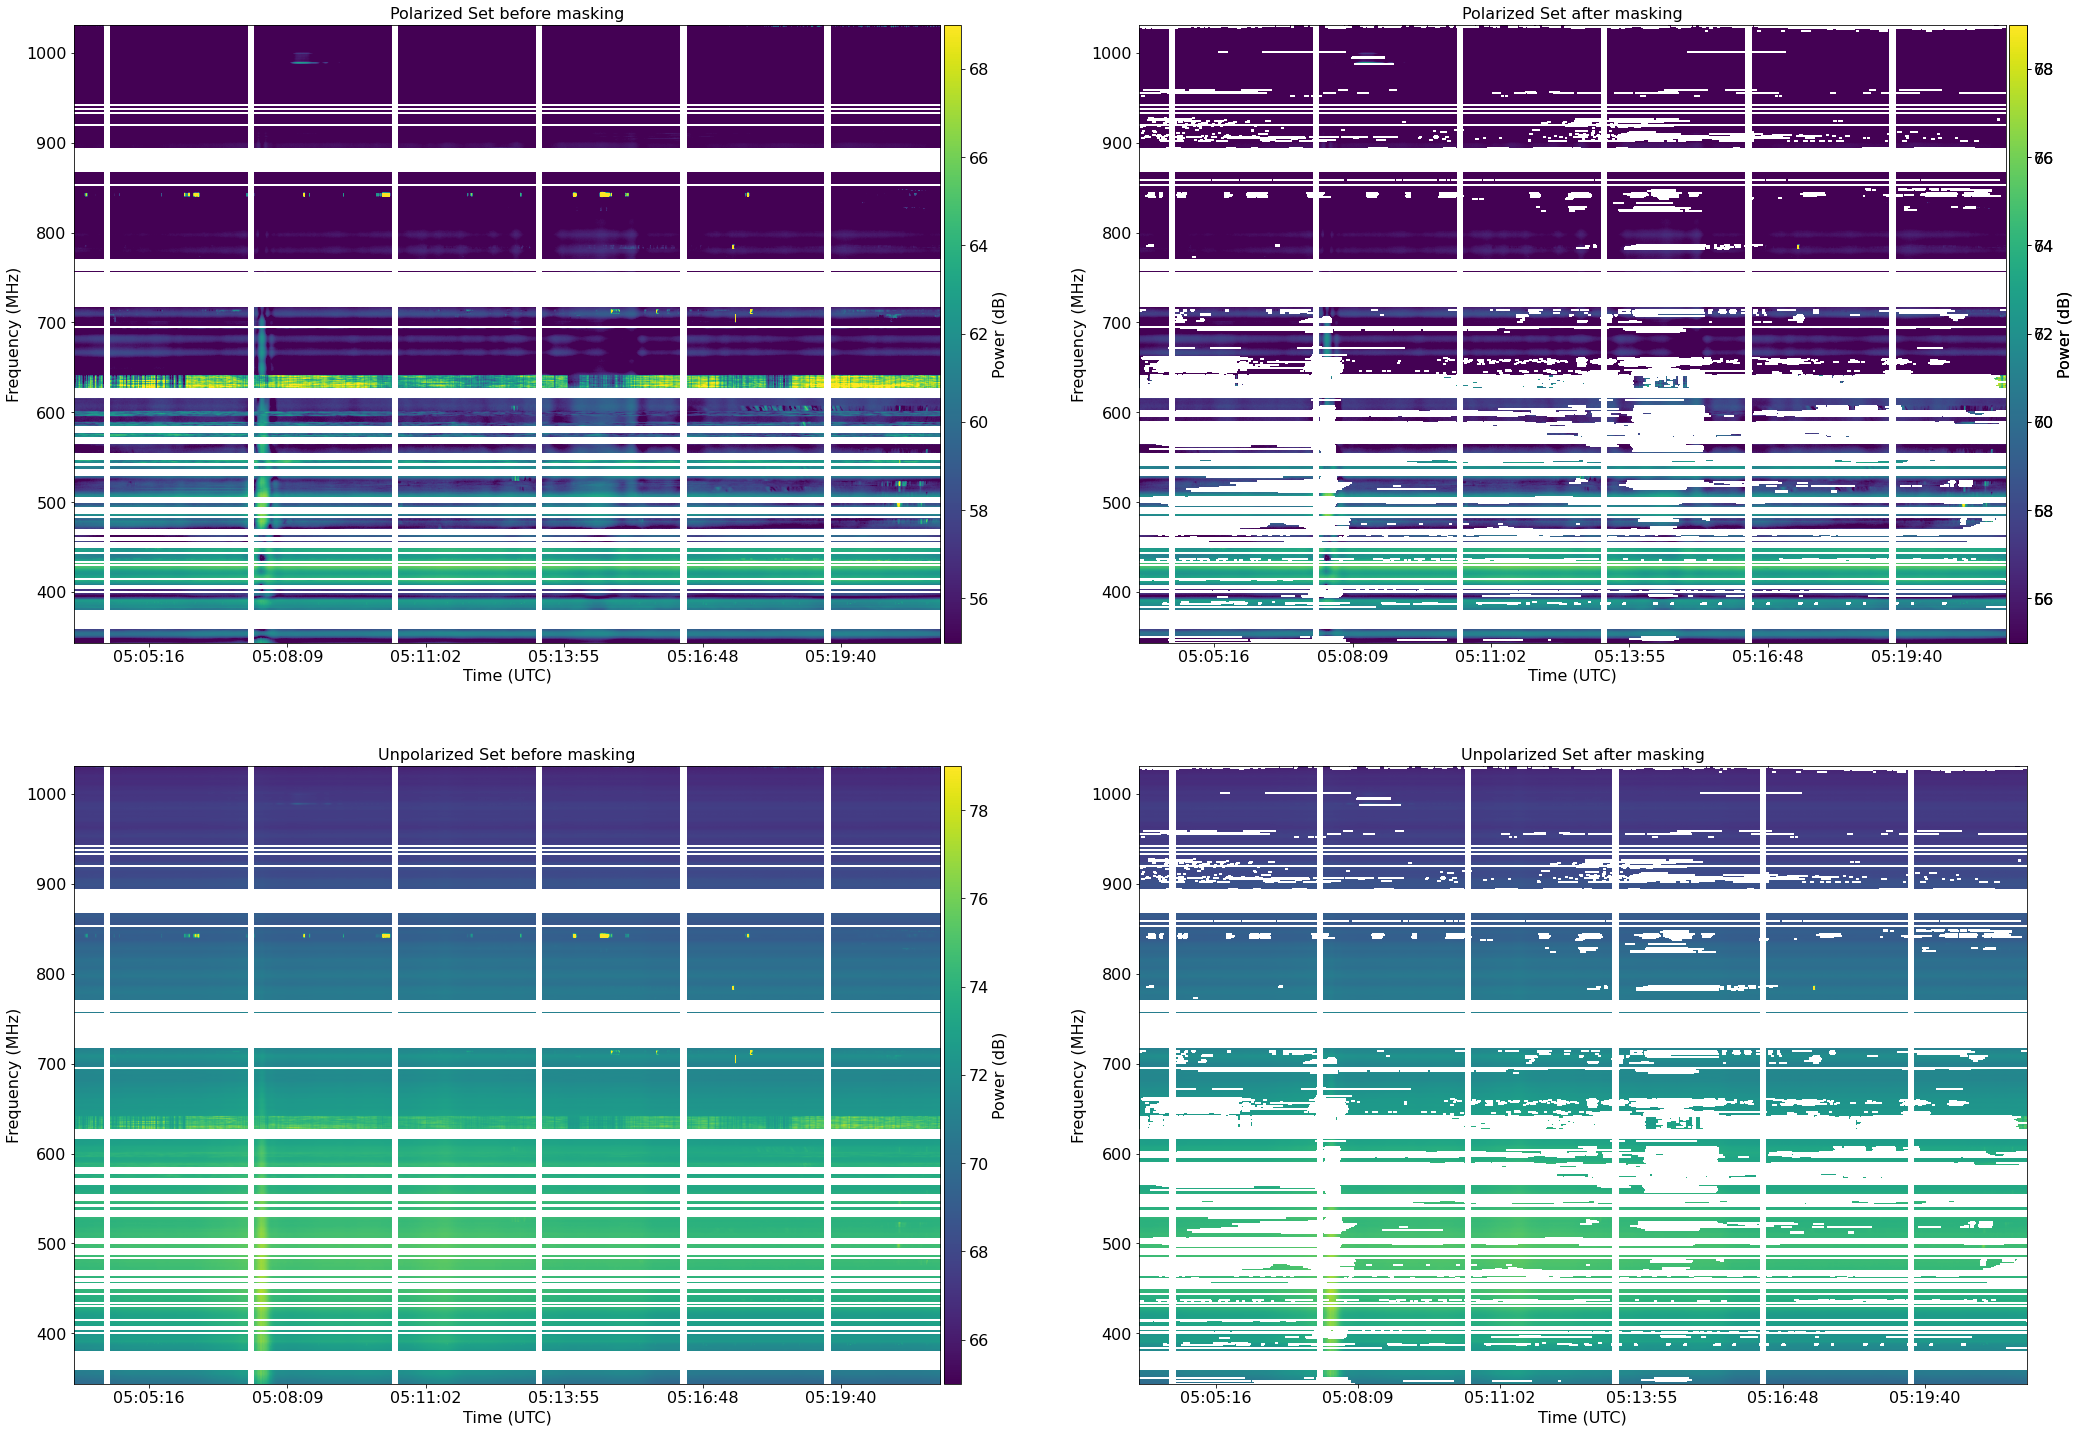

In [89]:
reload(rfi)
def DVA_Plot_RFI():
    freq_threshold = 1e5
    base_mult = 2

    polarized_set_masked = polarized_set.copy()
    LL_set_masked = LL_set.copy()
    for freq_idx in range(0, len(freq)-2): #test up to 20 for now
        confirmed_RFI_results = rfi.RFI_Detection(freq_slope_threshold=freq_threshold, freq_idx = freq_idx, baseline_multiplier=base_mult, polarized_set = polarized_set)
        confirmed_rfi_idxes = rfi.GenerateRfiIndexes(confirmed_RFI_results, t_plt)[0]
        polarized_set_masked[confirmed_rfi_idxes, freq_idx] = np.nan
        LL_set_masked[confirmed_rfi_idxes, freq_idx] = np.nan

    fig,axs = plt.subplots(2,2,figsize=(35,25))
    fs = 16
    #Polarized Waterfall ---------------------------------------------------------------------------------------------------------------------------
    polarized_power_min = 55
    polarized_power_max = 69
    im_pol = axs[0][0].imshow(10.*np.log10(polarized_set.T),aspect='auto',vmin=polarized_power_min,vmax=polarized_power_max,origin='lower',
            extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]])
    divider = make_axes_locatable(axs[0][0])
    cax = divider.append_axes('right', size='2%', pad=0.05)
    cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=fs) 
    cbar.set_label('Power (dB)', fontsize=fs)
    axs[0][0].set_xlim(t_plt[0],t_plt[-1])
    axs[0][0].tick_params(axis='both', labelsize=fs)
    axs[0][0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs[0][0].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs[0][0].set_xlabel('Time (UTC)',fontsize=fs)        
    axs[0][0].set_ylabel('Frequency (MHz)',fontsize=fs)
    axs[0][0].set_title('Polarized Set before masking', size = fs)
    
    #Polarized_Masked Waterfall ---------------------------------------------------------------------------------------------------------------------------
    im_pol = axs[0][1].imshow(10.*np.log10(polarized_set_masked.T),aspect='auto',vmin=polarized_power_min,vmax=polarized_power_max,origin='lower',
            extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]])
    divider = make_axes_locatable(axs[0][1])
    cax = divider.append_axes('right', size='2%', pad=0.05)
    cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=fs) 
    cbar.set_label('Power (dB)', fontsize=fs)
    axs[0][1].set_xlim(t_plt[0],t_plt[-1])
    axs[0][1].tick_params(axis='both', labelsize=fs)
    axs[0][1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs[0][1].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs[0][1].set_xlabel('Time (UTC)',fontsize=fs)        
    axs[0][1].set_ylabel('Frequency (MHz)',fontsize=fs)
    axs[0][1].set_title('Polarized Set after masking', size = fs)

    #PLL_set Unmasked Waterfall ---------------------------------------------------------------------------------------------------------------------------
    unpolarized_power_min = 65
    unpolarized_power_max = 79
    im_pol = axs[1][0].imshow(10.*np.log10(LL_set.T),aspect='auto',vmin=unpolarized_power_min,vmax=unpolarized_power_max,origin='lower',
            extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]])
    divider = make_axes_locatable(axs[1][0])
    cax = divider.append_axes('right', size='2%', pad=0.05)
    cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=fs) 
    cbar.set_label('Power (dB)', fontsize=fs)
    axs[1][0].set_xlim(t_plt[0],t_plt[-1])
    axs[1][0].tick_params(axis='both', labelsize=fs)
    axs[1][0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs[1][0].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs[1][0].set_xlabel('Time (UTC)',fontsize=fs)        
    axs[1][0].set_ylabel('Frequency (MHz)',fontsize=fs)
    axs[1][0].set_title('Unpolarized Set before masking', size = fs)

     #PLL_set Masked Waterfall ---------------------------------------------------------------------------------------------------------------------------
    unpolarized_power_min = 65
    unpolarized_power_max = 79
    im_pol = axs[1][1].imshow(10.*np.log10(LL_set_masked.T),aspect='auto',vmin=unpolarized_power_min,vmax=unpolarized_power_max,origin='lower',
            extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]])
    divider = make_axes_locatable(axs[0][1])
    cax = divider.append_axes('right', size='2%', pad=0.05)
    cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=fs) 
    cbar.set_label('Power (dB)', fontsize=fs)
    axs[1][1].set_xlim(t_plt[0],t_plt[-1])
    axs[1][1].tick_params(axis='both', labelsize=fs)
    axs[1][1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs[1][1].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs[1][1].set_xlabel('Time (UTC)',fontsize=fs)        
    axs[1][1].set_ylabel('Frequency (MHz)',fontsize=fs)
    axs[1][1].set_title('Unpolarized Set after masking', size = fs)
        
        

#Arbitraty constants for visualization   


DVA_Plot_RFI()


In [63]:
print(len(polarized_set[:,800]))


1804


# Idea:

When I'm finding a possible RFI:
- Find the first time I'm crossing the baseline to the left -> Mark that as the start
- Find the first time I'm crossing the baseline to the right -> Mark that as the end

# Today

Get a bin view of a specific frequency channel.

Use that to see if I can determine that values far fom 1 stn deviation are off


In [64]:
def plot_scan_histogram(polarized_set_masked, duration, freq_idx):
    polarized_set_masked[duration,freq_idx]
    hist, bin_edges = np.histogram(polarized_set_masked[duration,freq_idx], density=True)
    return hist



In [65]:
def exception(n):
    try:
        if n == 0:
            raise Exception("n=0 error")
        else:
            print("all fine")
    except Exception as err:
        print("Caught this error", repr(err))

In [66]:
exception(0)

Caught this error Exception('n=0 error')


# Ideas

Maybe I could try implementing the "variance" compression method:
- check the variance of 5 points. if below threshold, compress 5 values with the same baseline value.
- Note: 5 is an arbitrary choice. I could even have a larger variance interval, and if the variance is high, I start dividing my large interval into smaller chunks looking for the high variance intervals